In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time
import random
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

/Users/Daphne/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/Users/Daphne/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/Users/Daphne/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nump

In [2]:
df = pd.read_csv('opinions_since_1970.csv')

In [3]:
# Drop per curiam opinions
df = df[df.category != 'per_curiam']

In [4]:
# Combine dissenting and second dissenting into one category
df.category = df.category.map(lambda x: x if x != 'second_dissenting' else 'dissenting')

In [5]:
# drop least common authors (Roberts, Kagan, Black, Harlan)
authors_with_min_20 = df.author_name.value_counts()[df.author_name.value_counts() >= 20].index
df = df[df.author_name.isin(authors_with_min_20)]

In [6]:
#Split data for testing, training, andvalidation

test_index = np.random.choice(df.index, size=df.shape[0]//4, replace=False)
train_index = df.index[~df.index.isin(test_index)]

re_train_index = [i for i in range(df.shape[0]) if df.index[i] in train_index]
re_test_index = [i for i in range(df.shape[0]) if df.index[i] in test_index]

# split data
train_df = df.loc[train_index]
test_df = df.loc[test_index]


In [7]:
train_df.shape

(7671, 14)

In [8]:
test_df.shape

(2557, 14)

In [9]:
df.shape

(10228, 14)

In [10]:
#Testing lemmatizer
print(WordNetLemmatizer().lemmatize('went', pos = 'v'))

go


In [11]:
#Testing stemmer
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [12]:
#text preprocess
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [13]:
# Testing preprocessing function

doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'fail', 'time', 'like', 'replac']


In [13]:
op_clean = [] #optional, this creates dictionary out of entire corpus.

for doc in df.text:
    op_clean.append(preprocess(doc))

#Create dictionary of lemmatized words
dictionary = gensim.corpora.Dictionary(op_clean)

In [14]:
train_clean = [] #second attempt using testing and training splits
for doc in train_df.text:
    train_clean.append(preprocess(doc))

In [43]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

KeyboardInterrupt: 

In [16]:
#Create dictionary of lemmatized words for test set
dictionary_train = gensim.corpora.Dictionary(train_clean)

In [17]:
#Checking dictionary created

count = 0
for k, v in dictionary_train.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abid
1 abil
2 abl
3 abridg
4 absenc
5 absent
6 absolut
7 abus
8 accept
9 access
10 accomplish


In [18]:
#OPTIONAL: Remove very rare and common words: appearing < 15 times and appearing > 10% of all documents
dictionary_train.filter_extremes(no_below=15, no_above=0.10, keep_n= 100000)

In [19]:
#Create bag of words from test dictionary
op_bag = [dictionary_train.doc2bow(doc) for doc in train_clean]

In [84]:
op_bag[0]

[(0, 1),
 (1, 4),
 (2, 4),
 (3, 1),
 (4, 1),
 (5, 3),
 (6, 4),
 (7, 1),
 (8, 1),
 (9, 74),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 3),
 (15, 2),
 (16, 3),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 3),
 (21, 1),
 (22, 1),
 (23, 3),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 4),
 (35, 2),
 (36, 1),
 (37, 4),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 4),
 (44, 1),
 (45, 1),
 (46, 3),
 (47, 55),
 (48, 3),
 (49, 1),
 (50, 3),
 (51, 1),
 (52, 1),
 (53, 35),
 (54, 11),
 (55, 143),
 (56, 1),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 4),
 (62, 1),
 (63, 1),
 (64, 2),
 (65, 3),
 (66, 3),
 (67, 1),
 (68, 5),
 (69, 1),
 (70, 4),
 (71, 1),
 (72, 5),
 (73, 25),
 (74, 1),
 (75, 1),
 (76, 2),
 (77, 2),
 (78, 2),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 2),
 (86, 3),
 (87, 4),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 6),
 (95, 1),
 (96, 2),
 (97, 2),
 (98, 1),
 (99, 7),
 (1

In [104]:
#Preivew bag of words to make sure that it has been created (this prints a long doc...)
bow_doc_x = op_bag[0]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary_train[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("abid") appears 1 time.
Word 1 ("abridg") appears 4 time.
Word 2 ("actor") appears 4 time.
Word 3 ("addi") appears 1 time.
Word 4 ("admonish") appears 1 time.
Word 5 ("advoc") appears 3 time.
Word 6 ("affili") appears 4 time.
Word 7 ("age") appears 1 time.
Word 8 ("agement") appears 1 time.
Word 9 ("aggreg") appears 74 time.
Word 10 ("aliti") appears 1 time.
Word 11 ("alli") appears 1 time.
Word 12 ("alvarez") appears 1 time.
Word 13 ("america") appears 1 time.
Word 14 ("amici") appears 3 time.
Word 15 ("analyz") appears 2 time.
Word 16 ("appelle") appears 3 time.
Word 17 ("appendix") appears 1 time.
Word 18 ("april") appears 1 time.
Word 19 ("ardent") appears 1 time.
Word 20 ("arena") appears 3 time.
Word 21 ("arm") appears 1 time.
Word 22 ("asso") appears 1 time.
Word 23 ("associa") appears 3 time.
Word 24 ("ate") appears 1 time.
Word 25 ("audienc") appears 1 time.
Word 26 ("avenu") appears 2 time.
Word 27 ("averag") appears 1 time.
Word 28 ("backdrop") appears 1 time.
Word 2

In [20]:
#create topics. This takes a few minutes.
lda_model5 =  gensim.models.LdaMulticore(op_bag, 
                                   num_topics = 5, 
                                   id2word = dictionary_train,                                    
                                   passes = 10,
                                   random_state=1,
                                   workers = 2)

In [105]:
for idx, topic in lda_model5.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.013*"arbitr" + 0.009*"alien" + 0.008*"copyright" + 0.007*"bankruptci" + 0.006*"bargain" + 0.005*"seizur" + 0.005*"debtor" + 0.005*"privaci" + 0.004*"immigr" + 0.004*"vehicl"


Topic: 1 
Words: 0.025*"indian" + 0.018*"tribe" + 0.011*"militari" + 0.010*"treati" + 0.008*"tribal" + 0.008*"abort" + 0.006*"registr" + 0.005*"convent" + 0.004*"firearm" + 0.004*"eleventh"


Topic: 2 
Words: 0.019*"water" + 0.008*"fee" + 0.007*"child" + 0.007*"candid" + 0.007*"tax" + 0.006*"river" + 0.005*"parent" + 0.005*"master" + 0.005*"vessel" + 0.004*"navig"


Topic: 3 
Words: 0.011*"habea" + 0.008*"juror" + 0.007*"racial" + 0.007*"race" + 0.006*"mental" + 0.005*"plea" + 0.004*"guidelin" + 0.004*"parol" + 0.004*"corpus" + 0.004*"mitig"


Topic: 4 
Words: 0.009*"patent" + 0.009*"religi" + 0.006*"competit" + 0.005*"antitrust" + 0.004*"disabl" + 0.004*"religion" + 0.004*"carrier" + 0.004*"advertis" + 0.004*"fraud" + 0.004*"appelle"




In [18]:
#create topics. This takes a few minutes.
lda_model10 =  gensim.models.LdaMulticore(op_bag, 
                                   num_topics = 10, 
                                   id2word = dictionary_train,                                    
                                   passes = 20,
                                   random_state=1,
                                   workers = 2)

In [19]:
for idx, topic in lda_model10.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.011*"medic" + 0.011*"rate" + 0.011*"taxpay" + 0.008*"disabl" + 0.008*"abort" + 0.008*"rat" + 0.007*"commission" + 0.007*"tax" + 0.007*"hospit" + 0.007*"erisa"


Topic: 1 
Words: 0.012*"bankruptci" + 0.008*"debtor" + 0.008*"rico" + 0.007*"sovereign" + 0.007*"debt" + 0.007*"tort" + 0.007*"tax" + 0.007*"racial" + 0.007*"interst" + 0.006*"carrier"


Topic: 2 
Words: 0.039*"water" + 0.014*"river" + 0.010*"master" + 0.010*"candid" + 0.009*"navig" + 0.008*"pollut" + 0.008*"compact" + 0.008*"island" + 0.007*"project" + 0.007*"carolina"


Topic: 3 
Words: 0.028*"indian" + 0.021*"patent" + 0.020*"tribe" + 0.017*"foreign" + 0.015*"copyright" + 0.012*"fee" + 0.010*"treati" + 0.008*"tribal" + 0.008*"infring" + 0.006*"sovereign"


Topic: 4 
Words: 0.020*"habea" + 0.010*"juror" + 0.009*"plea" + 0.008*"prosecutor" + 0.008*"indict" + 0.007*"corpus" + 0.007*"jeopardi" + 0.007*"prejudic" + 0.007*"verdict" + 0.007*"doubl"


Topic: 5 
Words: 0.014*"alien" + 0.012*"drug" + 0.008*"guidelin

In [20]:
#create topics. This takes a few minutes.
lda_model20 =  gensim.models.LdaMulticore(op_bag, 
                                   num_topics = 20, 
                                   id2word = dictionary_train,                                    
                                   passes = 20,
                                   random_state=1,
                                   workers = 2)

In [21]:
for idx, topic in lda_model20.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.038*"medic" + 0.032*"drug" + 0.024*"disabl" + 0.021*"abort" + 0.020*"hospit" + 0.018*"patient" + 0.014*"physician" + 0.012*"claimant" + 0.010*"coal" + 0.009*"miner"


Topic: 1 
Words: 0.018*"carrier" + 0.017*"sovereign" + 0.014*"tort" + 0.012*"railroad" + 0.010*"municip" + 0.010*"eleventh" + 0.010*"punit" + 0.009*"neglig" + 0.008*"liabl" + 0.006*"recoveri"


Topic: 2 
Words: 0.059*"water" + 0.021*"river" + 0.015*"master" + 0.012*"compact" + 0.012*"island" + 0.011*"navig" + 0.011*"pollut" + 0.009*"project" + 0.009*"boundari" + 0.009*"alaska"


Topic: 3 
Words: 0.055*"indian" + 0.042*"patent" + 0.040*"tribe" + 0.030*"copyright" + 0.021*"foreign" + 0.017*"treati" + 0.017*"tribal" + 0.015*"infring" + 0.009*"sovereign" + 0.008*"copi"


Topic: 4 
Words: 0.051*"habea" + 0.019*"corpus" + 0.014*"erisa" + 0.012*"collater" + 0.012*"custodi" + 0.012*"detent" + 0.012*"releas" + 0.010*"pretrial" + 0.009*"exhaust" + 0.009*"toll"


Topic: 5 
Words: 0.020*"vessel" + 0.017*"retir" + 0

In [22]:
import wordcloud

In [20]:
lda_model30 =  gensim.models.LdaMulticore(op_bag, 
                                   num_topics = 30, 
                                   id2word = dictionary_train,                                    
                                   passes = 40,
                                   random_state = 1,
                                   workers = 2)

In [21]:
for idx, topic in lda_model30.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.055*"bankruptci" + 0.037*"debtor" + 0.033*"debt" + 0.027*"creditor" + 0.023*"chapter" + 0.023*"asset" + 0.018*"truste" + 0.015*"lien" + 0.015*"estat" + 0.012*"bond"


Topic: 1 
Words: 0.111*"indian" + 0.080*"tribe" + 0.034*"tribal" + 0.033*"treati" + 0.019*"eleventh" + 0.016*"fish" + 0.011*"sovereignti" + 0.010*"allot" + 0.009*"oklahoma" + 0.009*"abrog"


Topic: 2 
Words: 0.044*"tax" + 0.029*"taxpay" + 0.015*"taxat" + 0.014*"michigan" + 0.013*"wag" + 0.013*"maryland" + 0.012*"appelle" + 0.011*"refund" + 0.011*"earn" + 0.009*"export"


Topic: 3 
Words: 0.016*"mitig" + 0.016*"miranda" + 0.015*"confess" + 0.013*"mental" + 0.012*"interrog" + 0.011*"aggrav" + 0.010*"kill" + 0.010*"guilt" + 0.009*"incrimin" + 0.007*"juror"


Topic: 4 
Words: 0.029*"fraud" + 0.020*"stock" + 0.019*"invest" + 0.018*"deduct" + 0.012*"sharehold" + 0.011*"profit" + 0.011*"deposit" + 0.010*"loan" + 0.010*"taxpay" + 0.009*"asset"


Topic: 5 
Words: 0.023*"seizur" + 0.021*"privaci" + 0.015*"vehicl"

In [182]:
topic29 = lda_model30.show_topic(29)

In [183]:
print(topic29)

[('juror', 0.054303136), ('carrier', 0.031905323), ('railroad', 0.030391878), ('retroact', 0.028029108), ('eeoc', 0.024957756), ('adea', 0.016190633), ('retir', 0.014688407), ('peremptori', 0.013094495), ('imparti', 0.010841533), ('rail', 0.010591566)]


In [131]:
test_df.loc[df['case_name']=='United States v. Monsanto']

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
9451,Justice White,majority,False,United States v. Monsanto,1989-06-22,NaN,https://www.courtlistener.com/opinion/112310/u...,https://www.courtlistener.com/api/rest/v3/clus...,1989,1988-130,1.0,5.0,4.0,The questions presented here are whether the f...


In [136]:
num = 796
unseen_document = test_df.text[num]

In [138]:
# Data preprocessing step for the unseen document
bow_vector = dictionary_train.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model30[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model30.print_topic(index, 5)))

Score: 0.7247023582458496	 Topic: 0.029*"militari" + 0.026*"ordin" + 0.014*"obscen" + 0.014*"solicit" + 0.012*"mail"
Score: 0.0827193334698677	 Topic: 0.029*"vessel" + 0.019*"ship" + 0.015*"maritim" + 0.014*"violenc" + 0.014*"firearm"
Score: 0.06239354982972145	 Topic: 0.050*"religi" + 0.042*"bargain" + 0.024*"religion" + 0.015*"church" + 0.013*"nlrb"
Score: 0.035974107682704926	 Topic: 0.025*"disclosur" + 0.024*"advertis" + 0.011*"client" + 0.010*"profession" + 0.010*"appelle"
Score: 0.03008943609893322	 Topic: 0.036*"hospit" + 0.036*"abort" + 0.030*"patient" + 0.023*"physician" + 0.015*"reimburs"
Score: 0.01934957318007946	 Topic: 0.016*"mitig" + 0.016*"miranda" + 0.015*"confess" + 0.013*"mental" + 0.012*"interrog"
Score: 0.014815617352724075	 Topic: 0.044*"racial" + 0.040*"race" + 0.033*"student" + 0.016*"dispar" + 0.013*"segreg"
Score: 0.013975677080452442	 Topic: 0.095*"arbitr" + 0.049*"candid" + 0.035*"voter" + 0.020*"ballot" + 0.018*"elector"


In [22]:
train_df['topics'] = lda_model30.get_document_topics(op_bag)

In [23]:
train_df['topics'][0:10]

0     [(21, 0.115879506), (22, 0.15041582), (23, 0.0...
1     [(9, 0.051980592), (17, 0.027343847), (22, 0.0...
2     [(4, 0.034843087), (10, 0.013846784), (17, 0.0...
3     [(3, 0.018335229), (13, 0.6260043), (22, 0.226...
4     [(0, 0.045686495), (4, 0.02356114), (13, 0.613...
5                  [(8, 0.046097983), (28, 0.95259446)]
6                                     [(28, 0.9941047)]
9     [(8, 0.28189227), (9, 0.1641172), (11, 0.03396...
11    [(4, 0.35400778), (16, 0.18115199), (17, 0.055...
12    [(3, 0.076086216), (12, 0.044269364), (17, 0.3...
Name: topics, dtype: object

In [24]:
train_df['main_topic'] = [int(str(sorted(lda_model30[i],reverse=True,key=lambda x: x[1])[0][0]).zfill(3)) for i in op_bag]

In [25]:
train_df['main_topic'][9]

8

In [26]:
train_df['topics'][9]

[(8, 0.28189227),
 (9, 0.1641172),
 (11, 0.033962056),
 (15, 0.08145202),
 (17, 0.0144686885),
 (18, 0.031613126),
 (20, 0.20106868),
 (21, 0.18117772)]

In [27]:
sf = pd.DataFrame(data=train_df['topics'])
af = pd.DataFrame()

for i in range(30):
    af[str(i)]=[]

frames = [sf,af]
af = pd.concat(frames).fillna(0)

for i in range(7671):
    for j in range(len(train_df['topics'][i])):
        af[str(train_df['topics'][i][j][0])].loc[i] = train_df['topics'][i][j][1]

/Users/Daphne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


KeyError: 7

In [28]:
af['year_filed'] = train_df['year_filed']

In [29]:
af['author_name'] = train_df['author_name']

In [30]:
af['main_topic'] = train_df['main_topic']

In [31]:
af['case_name'] = train_df['case_name']

In [32]:
af.drop(columns=['topics'])

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,year_filed,author_name,main_topic,case_name
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.117691,0.537631,0.000000,0.030536,0.0,2014,Justice Roberts,26,McCutcheon v. Federal Election Comm'n
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.051981,...,0.000000,0.143142,0.584236,0.000000,0.020051,0.0,2014,Justice Thomas,26,McCutcheon v. Federal Election Comm'n
2,0.000000,0.0,0.0,0.000000,0.034843,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.117507,0.492794,0.000000,0.031615,0.0,2014,Justice Breyer,26,McCutcheon v. Federal Election Comm'n
3,0.000000,0.0,0.0,0.018335,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.072597,0.000000,0.000000,0.000000,0.043744,0.0,2014,Justice Kagan,13,Kaley v. United States
4,0.045686,0.0,0.0,0.000000,0.023561,0.0,0.0,0.0,0.0,0.000000,...,0.066859,0.000000,0.000000,0.038564,0.020371,0.0,2014,Justice Roberts,13,Kaley v. United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10984,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2012,Justice Kagan,1,Match-E-Be-Nash-She-Wish Band of Pottawatomi I...
10986,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1987,Justice O'Connor,15,Pilot Life Ins. Co. v. Dedeaux
10987,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1974,Justice Powell,23,"Gertz v. Robert Welch, Inc."
10989,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1974,Justice Burger,23,"Gertz v. Robert Welch, Inc."


In [33]:
topic_year = train_df.groupby('year_filed').agg('mean').main_topic.astype(int).sort_values()

In [48]:
occur = train_df.groupby(['year_filed', 'main_topic']).size()

In [62]:
topics_2000 = occur[2000]

In [63]:
topics_2000

main_topic
0      3
1      2
2      1
3      9
4      1
5      8
6      3
7      1
8      6
9      4
10     1
11     9
12     5
13     2
14     5
16     1
17     1
18     4
19     1
20     3
21     4
22     3
23     1
24    10
25    11
26    11
27     9
28     1
29     2
dtype: int64

In [64]:
topics_1990= occur[1990]

In [65]:
topics_1980= occur[1980]

In [66]:
topics_1970= occur[1970]

In [71]:
topics_2010 = occur[2010]

In [72]:
topics_2019 = occur[2019]

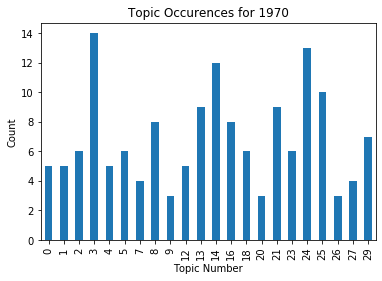

<Figure size 7200x7200 with 0 Axes>

In [67]:
plt.figure()
ax = topics_1970.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 1970")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

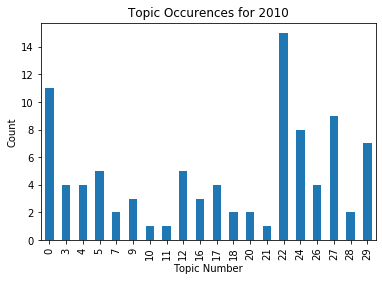

<Figure size 7200x7200 with 0 Axes>

In [73]:
plt.figure()
ax = topics_2010.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 2010")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

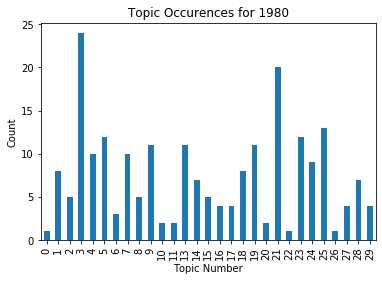

<Figure size 7200x7200 with 0 Axes>

In [68]:
plt.figure()
ax = topics_1980.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 1980")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

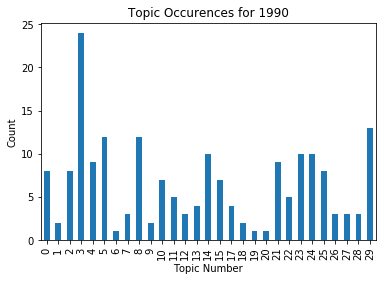

<Figure size 7200x7200 with 0 Axes>

In [69]:
plt.figure()
ax = topics_1990.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 1990")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

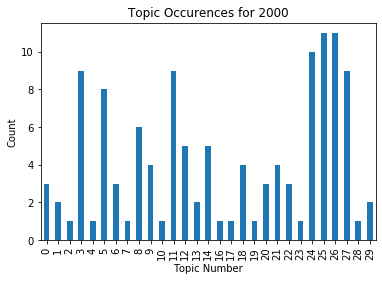

<Figure size 7200x7200 with 0 Axes>

In [70]:
plt.figure()
ax = topics_2000.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 2000")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

In [ ]:
plt.figure()
ax = topics_1970.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 1970")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

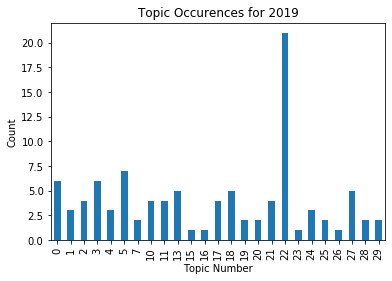

<Figure size 7200x7200 with 0 Axes>

In [74]:
plt.figure()
ax = topics_2019.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Topic Occurences for 2019")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

In [202]:
topic_counts = af['main_topic'].value_counts()

In [203]:
topic_counts

4     578
8     467
11    437
1     406
29    383
7     360
27    345
28    328
17    316
15    301
25    262
0     259
12    249
21    236
20    213
5     206
16    201
13    192
24    189
18    180
26    179
22    175
23    171
6     171
9     170
10    158
3     155
2     148
19    138
14     98
Name: main_topic, dtype: int64

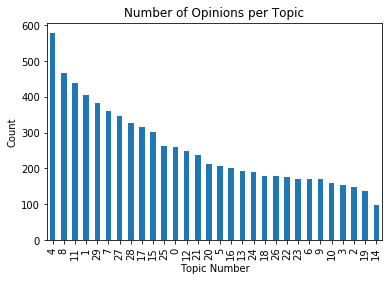

<Figure size 7200x7200 with 0 Axes>

In [214]:
plt.figure()
ax = topic_counts.plot(kind='bar')
plt.figure(figsize=(100,100))
ax.set_title("Number of Opinions per Topic")
ax.set_ylabel("Count")
ax.set_xlabel("Topic Number")
plt.show()

In [85]:
occur = train_df.groupby(['year_filed', 'main_topic').size()

SyntaxError: invalid syntax (<ipython-input-85-a934af787779>, line 1)